In [3]:
import netgen.gui
from netgen.geom2d import unit_square
from ngsolve import *
import pandas as pd

### Initializations

In [4]:
## Parameter setup
orders = [1, 2, 3]
beta = (2,0.001)
mesh_size = [1.0, 0.5, 0.25, 0.1250, 0.0625, 0.0313]
eps = 0.01

# Exact Solution
p = lambda x: x + (exp(beta[0]*x/eps)-1)/(1-exp(beta[0]/eps))
q = lambda y: y + (exp(beta[1]*y/eps)-1)/(1-exp(beta[1]/eps))
exact = p(x) * q(y)

#r = lambda x: beta[1] * (1 + ((exp(beta[0] * x / eps) - 1) / (1-exp(beta[0]/eps))))
#s = lambda y: beta[0] * (y + ((exp(beta[1] * y / eps) - 1)/  (1-exp(1/eps))))

coeff =  beta[1] * p(x) +  beta[0] * q(y)
#coeff = r(x) + s(y)

coeff_x = p(x)
coeff_y = q(y)

alpha = 10

### Enriched DG for variable (bonus_int_order)

In [4]:
columns = ['Order', 'Bonus Int', 'Mesh Size', 'Error']
edg_val = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        eps_size = 0.0001 * size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dgjumps=True)
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy], dgjumps = True)

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        ## Enrichment
        p = (coeff_x * px) + (coeff_y * py)
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        u_Other = us.Other() + coeff_x * px.Other() + coeff_y * py.Other()
        v_Other = vs.Other() + coeff_x * qx.Other() + coeff_y * qy.Other()
        
        jump_u = u - u_Other
        jump_v = v - v_Other
        
        n = specialcf.normal(2)
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        grad_uOther = grad(us.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py.Other() \
        + coeff_x * grad(px.Other()) + coeff_y * grad(py.Other())
        
        grad_vOther = grad(vs.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy.Other() \
        + coeff_x * grad(qx.Other()) + coeff_y * grad(qy.Other())
                
            
        mean_dudn = 0.5 * n * (grad_u + grad_uOther)
        mean_dvdn = 0.5 * n * (grad_v + grad_vOther)
        
        h = specialcf.mesh_size
        
        for val in range(0,20):
            # diffusion
            diffusion = grad_u * grad_v * dx(bonus_intorder = val) \
            + alpha * order**2/h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
            + (-mean_dudn* jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
            + alpha * order**2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
            + (-n * grad_u * v - n * grad_v * u) * ds(skeleton=True, bonus_intorder = val)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b*n, u, u_Other)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * v * dx(element_boundary=True, bonus_intorder = val)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder = val)
            f.Assemble()

            gfu = GridFunction(fes)
            try:
                gfu.vec.data = acd.mat.Inverse(inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(inverse="sparsecholesky") * f.vec
            
            u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y

            error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
            edg_val.loc[len(edg_val)] = [order, val, size, error] 
            
%store edg_val

NgException: UmfpackInverse: Numeric factorization failed.

### DG for variable (alpha)

In [1]:
columns = ['Order', 'Alpha', 'Mesh_Size', 'Error']
dg_alpha = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        fes = L2(mesh, order=order, dgjumps=True)
        u, v = fes.TnT()

        jump_u = u-u.Other()
        jump_v = v-v.Other()
        n = specialcf.normal(2)
        mean_dudn = 0.5 * n * (grad(u) + grad(u.Other()))
        mean_dvdn = 0.5 * n * (grad(v) + grad(v.Other()))

        h = specialcf.mesh_size

        # diffusion
        for alp in range(1, 20):
            diffusion = grad(u) * grad(v) * dx \
                +alp * order ** 2/ h * jump_u * jump_v * dx(skeleton=True) \
                +(-mean_dudn * jump_v - mean_dvdn * jump_u) * dx(skeleton=True) \
                +alp * order ** 2/h * u * v * ds(skeleton=True) \
                + (-n * grad(u) * v -n * grad(v) * u) * ds(skeleton=True)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b * n, u, u.Other())
            convection = -b * u * grad(v) * dx + b * n * uup * jump_v * dx(skeleton=True)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v)
            f.Assemble()

            gfu = GridFunction(fes, name="uDG")
            try:
                gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(inverse="sparsecholesky") * f.vec
            #gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            #Draw (gfu)

            error = sqrt (Integrate ((gfu-exact)*(gfu-exact), mesh))
            dg_alpha.loc[len(dg_alpha)] = [order, alp, size, error] 
            
%store dg_alpha

NameError: name 'pd' is not defined

### Enriched DG for variable (alpha)

In [5]:
columns = ['Order', 'Alpha', 'Mesh_Size', 'Error']
edg_alpha = pd.DataFrame(columns=columns)
val = 15 # bonusintorder
for order in orders:
    for size in mesh_size:
        eps_size = 0.000 * size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dgjumps=True)
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy], dgjumps = True)

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        ## Enrichment
        p = (coeff_x * px) + (coeff_y * py)
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        u_Other = us.Other() + coeff_x * px.Other() + coeff_y * py.Other()
        v_Other = vs.Other() + coeff_x * qx.Other() + coeff_y * qy.Other()
        
        jump_u = u - u_Other
        jump_v = v - v_Other
        
        n = specialcf.normal(2)
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        grad_uOther = grad(us.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py.Other() \
        + coeff_x * grad(px.Other()) + coeff_y * grad(py.Other())
        
        grad_vOther = grad(vs.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy.Other() \
        + coeff_x * grad(qx.Other()) + coeff_y * grad(qy.Other())
                
            
        mean_dudn = 0.5 * n * (grad_u + grad_uOther)
        mean_dvdn = 0.5 * n * (grad_v + grad_vOther)
        
        h = specialcf.mesh_size
        
        for alp in range(1, 20):     
            # diffusion
            diffusion = grad_u * grad_v * dx(bonus_intorder = val) \
            + alp * order**2/h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
            + (-mean_dudn* jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
            + alp * order**2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
            + (-n * grad_u * v - n * grad_v * u) * ds(skeleton=True, bonus_intorder = val)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b*n, u, u_Other)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * v * dx(element_boundary=True, bonus_intorder = val)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder = val)
            f.Assemble()

            gfu = GridFunction(fes)
            try:
                gfu.vec.data = acd.mat.Inverse(inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(inverse="sparsecholesky") * f.vec
            u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y

            error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
            edg_alpha.loc[len(edg_alpha)] = [order, alp, size, error] 
            #print('alpha', alp)
        #print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    #print('.......................................................................')
        
#Draw (gfu.components[2] * coeff_y, mesh, 'test')
%store edg_alpha

Stored 'edg_alpha' (DataFrame)


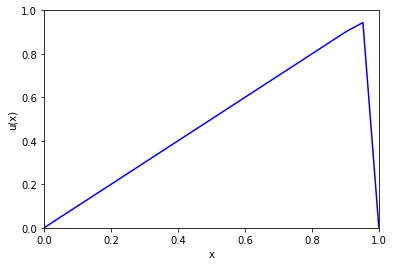

In [31]:
eps = 0.01
val = []
import numpy as np
import matplotlib.pyplot as plt
r = lambda x: x - (exp(-(1-x)/ eps) - exp(-1 / eps)) / (1-exp(-1/eps))
for x in np.linspace(0,1,22):
    val.append(r(x))
    
plt.plot(np.linspace(0,1,22), val, '-b', label='Exact solution u(x)')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

In [5]:
!ls

Convergence Analysis.ipynb example.py
Solver.ipynb               solver.py
Test Codes.ipynb


In [6]:
!ipython

]0;IPython: mastersthesis/ExamplesPython 3.7.5 (default, Nov 15 2019, 00:57:00) 
Type 'copyright', 'credits' or 'license' for more information
IPython 7.8.0 -- An enhanced Interactive Python. Type '?' for help.

C ?7h0mIn [1]:                                                                        In [1]:                                                                        

?7lIn [1]:                                                                        